## Prioritizer Model

Trained model for classification and prioritization for ALFABURST events based on the labelled feature set from  featureBuilder.ipynb.

### Classifier model

Probabalistic classifier using random forests.

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

### Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

#Read in preprocessed numpy arrays:
preProcFeats = np.load('./featuresold.npy')
preProcFeatsbin = np.load('./redfeatbin.npy')
preProcLabels = np.load('./processed.files/labelled/labelsnew.npy')
preProcLabelsbin = np.copy(preProcLabels)
preProcLabelsbin[preProcLabelsbin != 9] = 0
preProcLabelsbin[preProcLabelsbin == 9] = 1

#randstate = 200
folds = 10

## True pulses inspected vs total time series' inspected

In [2]:
clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0, warm_start=False), n_jobs=1)

clfbin = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0, warm_start=False), n_jobs=1)


split = sklearn.model_selection.StratifiedKFold(n_splits=folds).split(preProcFeats, preProcLabels)

# Multiclass and binary must be in the same loop so that the splits are the same (weird functionality of the)
# split attribute which does not return arrays as it should but a 'generator'
count = 0

# Loop over folds of train/test sets
for train, test in split:
    count += 1
    X_train = preProcFeats[train]
    X_test = preProcFeats[test]    
    y_train = preProcLabels[train]
    y_test = preProcLabels[test]
    
    X_trainbin = preProcFeatsbin[train]
    X_testbin = preProcFeatsbin[test]    
    y_trainbin = preProcLabelsbin[train]
    y_testbin = preProcLabelsbin[test]
        
    # Record number of pulses in the set for later
    npulses = np.argwhere(y_test==9).flatten().size
    npulsesbin = np.argwhere(y_testbin==1).flatten().size
    # Fit classifier
    probs = clf.fit(X_train, y_train).predict_proba(X_test)
    probsbin = clfbin.fit(X_trainbin, y_trainbin).predict_proba(X_testbin)
        
    # Add column for class label and sort by class 9 probability   
    probs = np.c_[probs, y_test]
    probs = probs[probs[:,7].argsort()][::-1]
    probsbin = np.c_[probsbin, y_testbin]
    probsbin = probsbin[probsbin[:,1].argsort()][::-1]
    
    # Define variables for later
    detcount = 0
    detections = np.zeros(probs.shape[0])
    detcountbin = 0
    detectionsbin = np.zeros(probs.shape[0])
    
    # Loop over rows in priority queue
    for i in range(probs.shape[0]):
        
        # If the data point is class 9, mark a detection
        if probs[i, 8] == 9:
            detcount += 1
            
        # Record number of detections after each 'inspection' and class 9 probability of the candidate
        detections[i] = detcount
        
    # Rescale to proportion of pulses found instead of absolute
    detections = detections/npulses
    
    # Avoid error if folds are slightly the wrong size
    if count > 2:
        while detections.size < detectpct.shape[1]:
            detections = np.append(detections, 1)
    if count == 2:
        while detections.size < detectpct.size:
            detections = np.append(detections, 1)
    
    # Loop over rows in priority queue
    for i in range(probsbin.shape[0]):
        
        # If the data point is class 9, mark a detection
        if probsbin[i, 2] == 1:
            detcountbin += 1
            
        # Record number of detections after each 'inspection' and class 9 probability of the candidate
        detectionsbin[i] = detcountbin
        
    # Rescale to proportion of pulses found instead of absolute
    detectionsbin = detectionsbin/npulsesbin
    
    # Avoid error if folds are slightly the wrong size
    if count > 2:
        while detectionsbin.size < detectpctbin.shape[1]:
            detectionsbin = np.append(detectionsbin, 1)
    if count == 2:
        while detectionsbin.size < detectpctbin.size:
            detectionsbin = np.append(detectionsbin, 1)

    
    print detections.shape, detectionsbin.shape
        
    # Stack recorded values for averaging
    if count == 1:
        detectpct = detections
        detectpctbin = detectionsbin
    else:
        detectpct = np.vstack((detectpct, detections))
        detectpctbin = np.vstack((detectpctbin, detectionsbin))
        
# Average over all folds
print detectpct.shape
detectpct = np.mean(detectpct, axis=0)
print detectpctbin.shape
detectpctbin = np.mean(detectpctbin, axis=0)

(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(1244,) (1244,)
(10, 1244)
(10, 1244)


In [3]:
candidatepct = np.arange(detectpct.size)+1
candidatepct = candidatepct.astype(float)

candidatepct = candidatepct/candidatepct.size
candidatepct = candidatepct.astype(float)

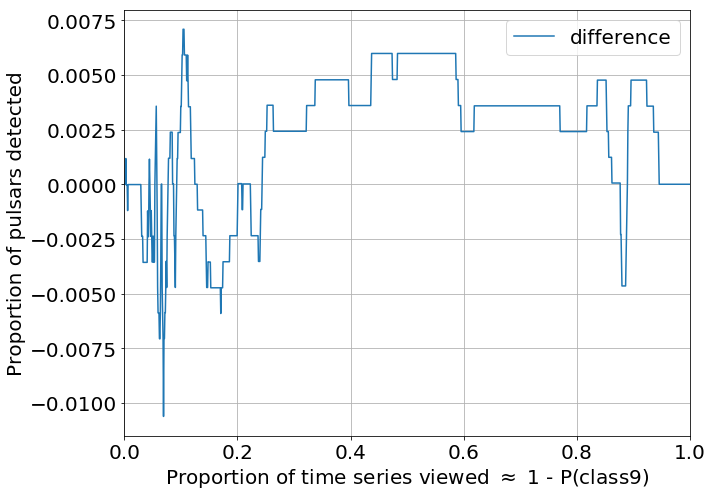

In [6]:
plt.figure(figsize=(10,7))
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.xlabel(r'Proportion of time series viewed $\approx$ 1 - P(class9)')
plt.ylabel('Proportion of pulsars detected')
plt.plot(candidatepct, detectpctbin-detectpct,  label = 'difference')
plt.grid()
plt.xlim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig('graphs/detectiondiff.png')
plt.show()

In [22]:
avg = np.array([])

split = sklearn.model_selection.StratifiedKFold(n_splits=folds).split(preProcFeatsbin, preProcLabelsbin)

for train, test in split:
    X_trainbin = preProcFeats[train]
    X_testbin = preProcFeats[test]    
    y_trainbin = preProcLabels[train]
    y_testbin = preProcLabels[test]

    probsbin = clfbin.fit(X_trainbin, y_trainbin).predict_proba(X_testbin)
    pulseargs = np.argwhere(y_testbin ==9).flatten()

    pulseprobs = np.hsplit(probsbin,8)[7]
    pulseprobs = pulseprobs[pulseargs]
    avg = np.append(avg, np.sum(pulseprobs)/pulseprobs.size)
    

In [25]:
print avg
print np.mean(avg)
print 1.34/np.mean(avg)

[ 0.60328154  0.84556042  0.99198612  0.74128633  0.97441064  0.73038776
  0.78747931  0.96817748  0.82468722  0.91008155]
0.837733835318
1.59955339454


In [ ]:
0.